In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

JSON_PATH = Path("../data/anilist_top10000.json")
JSON_PATH

WindowsPath('../data/anilist_top10000.json')

In [2]:
# JSON -> DataFrame
if not JSON_PATH.exists():
    raise FileNotFoundError("JSON 파일 없음!")

with JSON_PATH.open("r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,id,title,format,status,season,seasonYear,episodes,duration,averageScore,meanScore,popularity,favourites,genres,tags,studios,staff
0,16498,"{'romaji': 'Shingeki no Kyojin', 'english': 'A...",TV,FINISHED,SPRING,2013.0,25.0,24.0,85.0,85.0,922903,55725,"[Action, Drama, Fantasy, Mystery]","[{'name': 'Kaiju'}, {'name': 'Revenge'}, {'nam...","{'nodes': [{'name': 'WIT STUDIO'}, {'name': 'P...","{'nodes': [{'name': {'full': 'Yuu Kobayashi'},..."
1,101922,"{'romaji': 'Kimetsu no Yaiba', 'english': 'Dem...",TV,FINISHED,SPRING,2019.0,26.0,24.0,82.0,82.0,876638,42035,"[Action, Adventure, Drama, Fantasy, Supernatural]","[{'name': 'Demons'}, {'name': 'Shounen'}, {'na...","{'nodes': [{'name': 'ufotable'}, {'name': 'Ani...","{'nodes': [{'name': {'full': 'Steve Staley'}, ..."
2,1535,"{'romaji': 'DEATH NOTE', 'english': 'Death Not...",TV,FINISHED,FALL,2006.0,37.0,23.0,84.0,84.0,840282,44144,"[Mystery, Psychological, Supernatural, Thriller]","[{'name': 'Crime'}, {'name': 'Detective'}, {'n...","{'nodes': [{'name': 'MADHOUSE'}, {'name': 'VAP...","{'nodes': [{'name': {'full': 'Aya Hirano'}, 'p..."
3,113415,"{'romaji': 'Jujutsu Kaisen', 'english': 'JUJUT...",TV,FINISHED,FALL,2020.0,24.0,24.0,84.0,84.0,831217,49275,"[Action, Drama, Supernatural]","[{'name': 'Urban Fantasy'}, {'name': 'Shounen'...","{'nodes': [{'name': 'Toho'}, {'name': 'MAPPA'}...",{'nodes': [{'name': {'full': 'Michael Sorich'}...
4,21459,"{'romaji': 'Boku no Hero Academia', 'english':...",TV,FINISHED,SPRING,2016.0,13.0,24.0,76.0,76.0,777465,20687,"[Action, Adventure, Comedy]","[{'name': 'Super Power'}, {'name': 'Superhero'...","{'nodes': [{'name': 'bones'}, {'name': 'Dentsu...","{'nodes': [{'name': {'full': 'Justin Cook'}, '..."


In [3]:
# title 정규화
df["title_romaji"] = df["title"].apply(lambda x: (x or {}).get("romaji"))
df["title_english"] = df["title"].apply(lambda x: (x or {}).get("english"))
df["title_native"] = df["title"].apply(lambda x: (x or {}).get("native"))

In [4]:
df[["id","title_romaji","title_english","title_native"]].head()

,id,title_romaji,title_english,title_native
0,16498,Shingeki no Kyojin,Attack on Titan,進撃の巨人
1,101922,Kimetsu no Yaiba,Demon Slayer: Kimetsu no Yaiba,鬼滅の刃
2,1535,DEATH NOTE,Death Note,DEATH NOTE
3,113415,Jujutsu Kaisen,JUJUTSU KAISEN,呪術廻戦
4,21459,Boku no Hero Academia,My Hero Academia,僕のヒーローアカデミア


In [5]:
# tags -> name 리스트로 정리
# tags: list[{name: ...}, ...] 형태니까, name만 빼온다
def extract_tag_names(tag_list):
    if not isinstance(tag_list, list):
        return []
    return [t.get("name") for t in tag_list if isinstance(t, dict)]

df["tag_list"] = df["tags"].apply(extract_tag_names)
df["tag_list"].head()

0    [Kaiju, Revenge, Military, Tragedy, Post-Apoca...
1    [Demons, Shounen, Swordplay, Male Protagonist,...
2    [Crime, Detective, Anti-Hero, Male Protagonist...
3    [Urban Fantasy, Shounen, Youkai, Super Power, ...
4    [Super Power, Superhero, Shounen, Primarily Te...
Name: tag_list, dtype: object

In [6]:
# genres는 OHE(OneHot Encoding)하면 좋을듯?
df_genre = df[["id", "genres"]].explode("genres")
df_genre = df_genre.dropna(subset=["genres"])

genre_counts = df_genre["genres"].value_counts()
genre_counts

genres
Comedy           4452
Action           3725
Fantasy          2785
Drama            2525
Adventure        2412
Sci-Fi           2172
Romance          2095
Slice of Life    1831
Supernatural     1443
Ecchi             866
Mecha             863
Mystery           781
Sports            591
Music             533
Psychological     482
Horror            389
Mahou Shoujo      334
Thriller          200
Name: count, dtype: int64

In [7]:
df_genre_ohe = pd.get_dummies(df_genre["genres"], prefix="genre")
df_genre_ohe = pd.concat([df_genre[["id"]], df_genre_ohe], axis=1)
df_genre_ohe = df_genre_ohe.groupby("id", as_index=False).sum()

df_genre_ohe.head()

,id,genre_Action,genre_Adventure,genre_Comedy,genre_Drama,genre_Ecchi,genre_Fantasy,genre_Horror,genre_Mahou Shoujo,genre_Mecha,genre_Music,genre_Mystery,genre_Psychological,genre_Romance,genre_Sci-Fi,genre_Slice of Life,genre_Sports,genre_Supernatural,genre_Thriller
0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,6,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
# tags도 OHE
df_tag = df[["id", "tag_list"]].explode("tag_list")
df_tag = df_tag.dropna(subset=["tag_list"])

tag_counts = df_tag["tag_list"].value_counts()
tag_counts

tag_list
Male Protagonist         3825
Female Protagonist       3325
School                   2369
Primarily Female Cast    1893
Shounen                  1815
                         ... 
4-koma                      1
Irrumatio                   1
Pet Play                    1
Sweat                       1
Defloration                 1
Name: count, Length: 391, dtype: int64

In [9]:
# tags는 Top200만 쓰자
TOP_N_TAGS = 200
top_tags = tag_counts.head(TOP_N_TAGS).index.tolist()

df_tag_filtered = df_tag[df_tag["tag_list"].isin(top_tags)]

In [10]:
df_tag_ohe = pd.get_dummies(df_tag_filtered["tag_list"], prefix="tag")
df_tag_ohe = pd.concat([df_tag_filtered[["id"]], df_tag_ohe], axis=1)
df_tag_ohe = df_tag_ohe.groupby("id", as_index=False).sum()

df_tag_ohe.head()

,id,tag_Achronological Order,tag_Acting,tag_Adoption,tag_Advertisement,tag_Afterlife,tag_Age Gap,tag_Age Regression,tag_Aliens,tag_Alternate Universe,tag_Amnesia,tag_Anachronism,tag_Angels,tag_Animals,tag_Anthropomorphism,tag_Anti-Hero,tag_Archery,tag_Artificial Intelligence,tag_Assassins,tag_Athletics,tag_Aviation,tag_Band,tag_Baseball,tag_Battle Royale,tag_Bisexual,tag_Body Horror,tag_Body Swapping,tag_Boys' Love,tag_Bullying,tag_CGI,tag_Card Battle,tag_Cars,tag_Chibi,tag_Chuunibyou,tag_Class Struggle,tag_Classic Literature,tag_Clone,tag_Coastal,tag_Cohabitation,tag_College,tag_Coming of Age,tag_Conspiracy,tag_Cosmic Horror,tag_Crime,tag_Crossdressing,tag_Crossover,tag_Cult,tag_Cultivation,tag_Curses,tag_Cute Boys Doing Cute Things,tag_Cute Girls Doing Cute Things,tag_Cyberpunk,tag_Cyborg,tag_Dancing,tag_Delinquents,tag_Demons,tag_Denpa,tag_Desert,tag_Detective,tag_Disability,tag_Dissociative Identities,tag_Dragons,tag_Drawing,tag_Drugs,tag_Dungeon,tag_Dystopian,tag_Educational,tag_Elf,tag_Ensemble Cast,tag_Environmental,tag_Episodic,tag_Espionage,tag_Fairy,tag_Fairy Tale,tag_Family Life,tag_Female Harem,tag_Female Protagonist,tag_Femboy,tag_Food,tag_Foreign,tag_Found Family,tag_Fugitive,tag_Full CGI,tag_Gangs,tag_Gender Bending,tag_Ghost,tag_Gods,tag_Gore,tag_Guns,tag_Gyaru,tag_Henshin,tag_Heterosexual,tag_Hikikomori,tag_Historical,tag_Idol,tag_Incest,tag_Isekai,tag_Iyashikei,tag_Josei,tag_Kaiju,tag_Kemonomimi,tag_Kids,tag_Kuudere,tag_LGBTQ+ Themes,tag_Language Barrier,tag_Lost Civilization,tag_Love Triangle,tag_Magic,tag_Maids,tag_Male Harem,tag_Male Protagonist,tag_Marriage,tag_Martial Arts,tag_Medieval,tag_Memory Manipulation,tag_Meta,tag_Military,tag_Monster Girl,tag_Motorcycles,tag_Musical Theater,tag_Mythology,tag_Nekomimi,tag_Ninja,tag_No Dialogue,tag_Nudity,tag_Ojou-sama,tag_Orphan,tag_Otaku Culture,tag_Outdoor Activities,tag_Parody,tag_Philosophy,tag_Pirates,tag_Police,tag_Politics,tag_Post-Apocalyptic,tag_Primarily Adult Cast,tag_Primarily Child Cast,tag_Primarily Female Cast,tag_Primarily Male Cast,tag_Primarily Teen Cast,tag_Proxy Battle,tag_Rape,tag_Real Robot,tag_Rehabilitation,tag_Reincarnation,tag_Religion,tag_Revenge,tag_Robots,tag_Royal Affairs,tag_Rural,tag_Samurai,tag_Satire,tag_School,tag_School Club,tag_Seinen,tag_Shapeshifting,tag_Ships,tag_Shoujo,tag_Shounen,tag_Shrine Maiden,tag_Slapstick,tag_Slavery,tag_Snowscape,tag_Space,tag_Space Opera,tag_Spearplay,tag_Steampunk,tag_Suicide,tag_Super Power,tag_Super Robot,tag_Superhero,tag_Surreal Comedy,tag_Survival,tag_Swordplay,tag_Tanned Skin,tag_Teacher,tag_Terrorism,tag_Time Manipulation,tag_Time Skip,tag_Tokusatsu,tag_Tomboy,tag_Tragedy,tag_Trains,tag_Transgender,tag_Travel,tag_Tsundere,tag_Twins,tag_Unrequited Love,tag_Urban,tag_Urban Fantasy,tag_Vampire,tag_Video Games,tag_Virtual World,tag_War,tag_Witch,tag_Work,tag_Yakuza,tag_Yandere,tag_Youkai,tag_Yuri,tag_Zombie
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0

In [11]:
# studios는 개많으니까, OHE 안하는게 나을듯
# 하는게 더 유의미할 수도 ?
def extract_studio_names(studio_obj):
    if not isinstance(studio_obj, dict):
        return []
    return [n.get("name") for n in (studio_obj.get("nodes") or []) if isinstance(n, dict)]

df["studios_list"] = df["studios"].apply(extract_studio_names)
df[["id", "studios_list"]].head()

,id,studios_list
0,16498,"[WIT STUDIO, Pony Canyon, Kodansha, Production..."
1,101922,"[ufotable, Aniplex, Shueisha, Aniplex of Ameri..."
2,1535,"[MADHOUSE, VAP, Viz Media, Nippon Television N..."
3,113415,"[Toho, MAPPA, Shueisha, Sumzap, Mainichi Broad..."
4,21459,"[bones, Dentsu, Mainichi Broadcasting System, ..."


In [12]:
drop_cols = ["title", "tags", "studios", "staff"]

df_base = df.drop(columns=[c for c in drop_cols if c in df.columns])

df_final = (
    df_base
    .merge(df_genre_ohe, on="id", how="left")
    .merge(df_tag_ohe, on="id", how="left")
)

df_final.head()

,id,format,status,season,seasonYear,episodes,duration,averageScore,meanScore,popularity,favourites,genres,title_romaji,title_english,title_native,tag_list,studios_list,genre_Action,genre_Adventure,genre_Comedy,genre_Drama,genre_Ecchi,genre_Fantasy,genre_Horror,genre_Mahou Shoujo,genre_Mecha,genre_Music,genre_Mystery,genre_Psychological,genre_Romance,genre_Sci-Fi,genre_Slice of Life,genre_Sports,genre_Supernatural,genre_Thriller,tag_Achronological Order,tag_Acting,tag_Adoption,tag_Advertisement,tag_Afterlife,tag_Age Gap,tag_Age Regression,tag_Aliens,tag_Alternate Universe,tag_Amnesia,tag_Anachronism,tag_Angels,tag_Animals,tag_Anthropomorphism,tag_Anti-Hero,tag_Archery,tag_Artificial Intelligence,tag_Assassins,tag_Athletics,tag_Aviation,tag_Band,tag_Baseball,tag_Battle Royale,tag_Bisexual,tag_Body Horror,tag_Body Swapping,tag_Boys' Love,tag_Bullying,tag_CGI,tag_Card Battle,tag_Cars,tag_Chibi,tag_Chuunibyou,tag_Class Struggle,tag_Classic Literature,tag_Clone,tag_Coastal,tag_Cohabitation,tag_College,tag_Coming of Age,tag_Conspiracy,tag_Cosmic Horror,tag_Crime,tag_Crossdressing,tag_Crossover,tag_Cult,tag_Cultivation,tag_Curses,tag_Cute Boys Doing Cute Things,tag_Cute Girls Doing Cute Things,tag_Cyberpunk,tag_Cyborg,tag_Dancing,tag_Delinquents,tag_Demons,tag_Denpa,tag_Desert,tag_Detective,tag_Disability,tag_Dissociative Identities,tag_Dragons,tag_Drawing,tag_Drugs,tag_Dungeon,tag_Dystopian,tag_Educational,tag_Elf,tag_Ensemble Cast,tag_Environmental,tag_Episodic,tag_Espionage,tag_Fairy,tag_Fairy Tale,tag_Family Life,tag_Female Harem,tag_Female Protagonist,tag_Femboy,tag_Food,tag_Foreign,tag_Found Family,tag_Fugitive,tag_Full CGI,tag_Gangs,tag_Gender Bending,tag_Ghost,tag_Gods,tag_Gore,tag_Guns,tag_Gyaru,tag_Henshin,tag_Heterosexual,tag_Hikikomori,tag_Historical,tag_Idol,tag_Incest,tag_Isekai,tag_Iyashikei,tag_Josei,tag_Kaiju,tag_Kemonomimi,tag_Kids,tag_Kuudere,tag_LGBTQ+ Themes,tag_Language Barrier,tag_Lost Civilization,tag_Love Triangle,tag_Magic,tag_Maids,tag_Male Harem,tag_Male Protagonist,tag_Marriage,tag_Martial Arts,tag_Medieval,tag_Memory Manipulation,tag_Meta,tag_Military,tag_Monster Girl,tag_Motorcycles,tag_Musical Theater,tag_Mythology,tag_Nekomimi,tag_Ninja,tag_No Dialogue,tag_Nudity,tag_Ojou-sama,tag_Orphan,tag_Otaku Culture,tag_Outdoor Activities,tag_Parody,tag_Philosophy,tag_Pirates,tag_Police,tag_Politics,tag_Post-Apocalyptic,tag_Primarily Adult Cast,tag_Primarily Child Cast,tag_Primarily Female Cast,tag_Primarily Male Cast,tag_Primarily Teen Cast,tag_Proxy Battle,tag_Rape,tag_Real Robot,tag_Rehabilitation,tag_Reincarnation,tag_Religion,tag_Revenge,tag_Robots,tag_Royal Affairs,tag_Rural,tag_Samurai,tag_Satire,tag_School,tag_School Club,tag_Seinen,tag_Shapeshifting,tag_Ships,tag_Shoujo,tag_Shounen,tag_Shrine Maiden,tag_Slapstick,tag_Slavery,tag_Snowscape,tag_Space,tag_Space Opera,tag_Spearplay,tag_Steampunk,tag_Suicide,tag_Super Power,tag_Super Robot,tag_Superhero,tag_Surreal Comedy,tag_Survival,tag_Swordplay,tag_Tanned Skin,tag_Teacher,tag_Terrorism,tag_Time Manipulation,tag_Time Skip,tag_Tokusatsu,tag_Tomboy,tag_Tragedy,tag_Trains,tag_Transgender,tag_Travel,tag_Tsundere,tag_Twins,tag_Unrequited Love,tag_Urban,tag_Urban Fantasy,tag_Vampire,tag_Video Games,tag_Virtual World,tag_War,tag_Witch,tag_Work,tag_Yakuza,tag_Yandere,tag_Youkai,tag_Yuri,tag_Zombie
0,16498,TV,FINISHED,SPRING,2013.0,25.0,24.0,85.0,85.0,922903,55725,"[Action, Drama, Fantasy, Mystery]",Shingeki no Kyojin,Attack on Titan,進撃の巨人,"[Kaiju, Revenge, Military, Tragedy, Post-Apoca...","[WIT STUDIO, Pony Canyon, Kodansha, Production...",1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0

In [13]:
df_final.to_csv("anilist_top10000_eda.csv", index=False, encoding="utf-8")

try:
    import fastparquet  # 엔진 강제 사용 전, import 테스트

    df_final.to_parquet(
        "anilist_top10000_eda.parquet",
        index=False,
        engine="fastparquet",  # ← 이게 포인트
    )
    print("Parquet 저장 성공 (engine = fastparquet)")

except Exception as e:
    import traceback
    print("Parquet 저장 중 예외 발생:")
    traceback.print_exc()

Parquet 저장 중 예외 발생:


Traceback (most recent call last):
  File "C:\Users\Playdata\AppData\Local\Temp\ipykernel_17788\3183993834.py", line 4, in <module>
    import fastparquet  # 엔진 강제 사용 전, import 테스트
    ^^^^^^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'fastparquet'


In [23]:
numeric_cols = [
    "averageScore",
    "meanScore",
    "popularity",
    "favourites",
    "episodes",
    "duration",
]

top_genre_cols = [f"genre_{g}" for g in genre_counts.head(10).index]
top_tag_cols = [f"tag_{t}" for t in tag_counts.head(10).index if f"tag_{t}" in df_final.columns]

cols_for_corr = numeric_cols + top_genre_cols + top_tag_cols

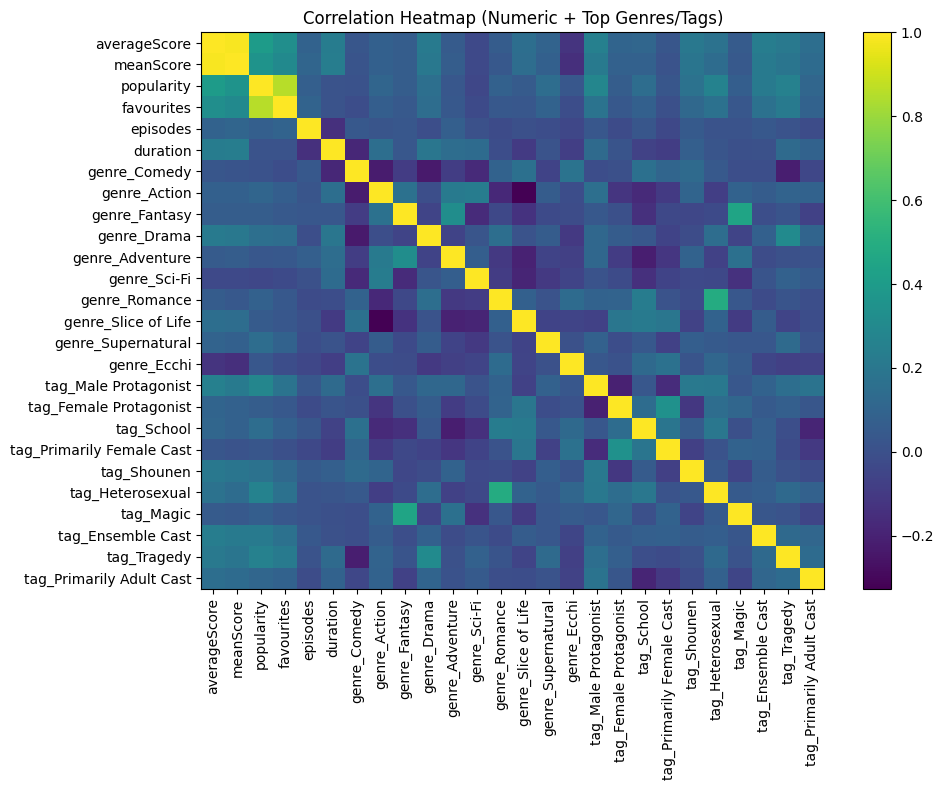

In [24]:
corr = df_final[cols_for_corr].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(cols_for_corr)), cols_for_corr, rotation=90)
plt.yticks(range(len(cols_for_corr)), cols_for_corr)
plt.title("Correlation Heatmap (Numeric + Top Genres/Tags)")
plt.tight_layout()
plt.show()